# Matching Model
To find the expected effect of the intervention on the population, we match each treated individual with one or more untreated individuals which are "almost the same" as him or her.

In [1]:
from causallib.estimation import IPW, Matching
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from causallib.evaluation.metrics import calculate_covariate_balance
from sklearn.linear_model import LogisticRegression
from causallib.preprocessing.transformers import PropensityTransformer, MatchingTransformer
from causallib.datasets import load_nhefs
%matplotlib inline

#### Data:
The effect of quitting to smoke on weight loss.  
Data example is taken from [Hernan and Robins Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

When we are looking for nearby data points to match against, the one hot encoding may not be the best choice. Augmented features are also not needed and may introduce bias (eg,  if we inlude `age^2`, we will call one pair of subjects more distant in the age variable than another pair if the base age is older, even though the difference is the same ). So we do not augment the continuous variables, and instead of one hot encoding the categorical variables, we binarize them to "high/low" values.

In [2]:
def binarize(df, column_name):
    df = df.copy()
    m = df[column_name].median()
    def balance(i): return np.abs(0.5 - (df[column_name] < i).sum()/len(df))
    mstar = min([m-1, m, m+1], key=balance)
    df = df.assign(**{column_name: (df[column_name] < mstar).astype(int)})
    df = df.rename(columns={column_name: column_name + f"<{mstar}"})
    return df


def get_matching_data():
    data = load_nhefs(onehot=False, augment=False)
    data.X = binarize(data.X, "education")
    data.X = binarize(data.X, "exercise")
    data.X = binarize(data.X, "active")
    return data


binarized_data = get_matching_data()
X, a, y = binarized_data.X, binarized_data.a, binarized_data.y

In [3]:
binarized_data.X.join(binarized_data.a).join(binarized_data.y).head()

,active<1.0,age,education<3.0,exercise<2.0,race,sex,smokeintensity,smokeyrs,wt71,qsmk,wt82_71
0,1,42,1,0,1,0,30,29,79.04,0,-10.093960
1,1,36,1,1,0,0,20,24,58.63,0,2.604970
2,1,56,1,0,1,1,20,26,56.81,0,9.414486
3,0,68,1,0,1,0,3,53,59.42,0,4.990117
4,0,40,1,1,0,0,20,19,87.09,0,4.989251


We can run either a Euclidean or a Mahalanobis metric match and predict the individual outcome using `MatchingIndividualOutcomeEstimator`:

In [4]:
m_euclid = Matching(metric="euclidean").fit(X, a, y)
m_mahalanobis = Matching(metric="mahalanobis").fit(X, a, y)
Y_euclid = m_euclid.estimate_individual_outcome(X, a)
Y_mahalanobis = m_mahalanobis.estimate_individual_outcome(X, a)

We can see that the two metrics lead to very similar results on a population level.

In [5]:
Y_euclid.assign(ATE=Y_euclid[1]-Y_euclid[0]).mean()

0      1.712532
1      5.562541
ATE    3.850009
dtype: float64

In [6]:
Y_mahalanobis.assign(ATE=Y_mahalanobis[1]-Y_mahalanobis[0]).mean()

0      1.862848
1      5.084078
ATE    3.221230
dtype: float64

If we inspect the individual counterfactuals, we find, as expected that both metrics return the same value for the observed outcome but differ in the unobserved outcome:

In [7]:
Y_euclid.join(Y_mahalanobis, lsuffix="_euclidean",
              rsuffix="_mahalanobis").join(a).sample(10)

,0_euclidean,1_euclidean,0_mahalanobis,1_mahalanobis,qsmk
sample_id,,,,,
270,-1.585221,-14.515030,-1.358036,-14.515030,1
1231,-1.478036,-2.152889,-1.478036,6.354588,0
312,4.994384,5.214677,4.994384,2.611378,0
747,8.052550,20.983137,8.052550,-20.751731,0
1286,-0.453769,4.653709,-0.453769,7.375747,0
660,2.044486,12.582741,2.044486,21.207697,0
97,14.738576,7.706729,14.738576,6.917506,0
661,-14.289883,-2.152889,3.518181,-2.152889,1
1097,-2.610177,6.348855,-2.610177,-2.722508,0


# Propensity Matching

To do propensity score matching, we can supply a transformer that replaces the covariates with a learned propensity model, using a given learner.

In [8]:
propensity_transform = PropensityTransformer(
    learner=LogisticRegression(
        solver="liblinear",
        class_weight="balanced"),
    include_covariates=False)

In this case we will want to use the augmented data to improve the accuracy of the propensity model.  We can calculate the ATE:

In [9]:
augmented_data = load_nhefs()
X, a, y = augmented_data.X, augmented_data.a, augmented_data.y
matcher = Matching(propensity_transform=propensity_transform)
matcher.fit(X, a, y)
matcher.estimate_population_outcome(X, a)

0    1.726202
1    4.682503
dtype: float64

We have also provided a convenience subclass `PropensityMatching` which makes this common task straightforward:

In [10]:
from causallib.estimation import PropensityMatching

pm = PropensityMatching(learner=LogisticRegression(
    solver="liblinear",
    class_weight="balanced"))
pm.fit(X, a, y)
pm.estimate_population_outcome(X, a)

0    1.726202
1    4.682503
dtype: float64

## Multiple neighbor match (with replacement)
As long as we permit replacement, we can allow multiple neighbors to match. We now check how the number of neighbors impacts the ATE.

In [11]:
for n in range(1, 10):
    matcher.n_neighbors = n
    matcher.fit(X, a, y)
    Y = matcher.estimate_population_outcome(X, a)
    print(f"Using {n} neighbors, the effect is: {(Y[1] - Y[0]):.3f}")

Using 1 neighbors, the effect is: 2.956
Using 2 neighbors, the effect is: 3.189
Using 3 neighbors, the effect is: 3.242
Using 4 neighbors, the effect is: 3.176
Using 5 neighbors, the effect is: 3.211
Using 6 neighbors, the effect is: 3.188
Using 7 neighbors, the effect is: 3.141
Using 8 neighbors, the effect is: 3.196
Using 9 neighbors, the effect is: 3.219


## Replacement 

Until now, we have executed all of the matching with replacement, meaning that we can select the same treated sample as a match for multiple control samples or vice versa. If we want to only allow each sample to be used once, we must disallow replacement. 

If we mix in-sample and out-of-sample data, we would end up generating different estimated counterfactuals for a set of samples if they were checked all at once compared to if they were checked in subsets. Because of this, we have restricted no-replacement matching to operate on a single dataset only as a `PopulationOutcomeEstimator` called `Matching`.

In [12]:
matcher = Matching(with_replacement=True, propensity_transform=propensity_transform)
matcher.fit(X, a, y)
match_df_with = matcher.match(X, a)
ATE_with_replacement = matcher.estimate_population_outcome(X, a).diff()[1]

In [13]:
matcher = Matching(with_replacement=False, propensity_transform=propensity_transform)
matcher.fit(X, a, y)
match_df_without = matcher.match(X, a)
ATE_without_replacement = matcher.estimate_population_outcome(X, a).diff()[1]

In [14]:
print(
    f"With replacement we find:\n{ATE_with_replacement:.3f}\nWithout replacement we find:\n{ATE_without_replacement:.3f}")

With replacement we find:
2.956
Without replacement we find:
3.426


In [15]:
ipw = IPW(LogisticRegression(solver="liblinear"))
ipw.fit(augmented_data.X, augmented_data.a)
Yipw = ipw.estimate_population_outcome(
    augmented_data.X, augmented_data.a, augmented_data.y)
ATE_ipw = Yipw[1] - Yipw[0]
ATE_naive = y[a == 1].mean() - y[a == 0].mean()

print(
    f"With IPW we find:\n{ATE_ipw:.3f}\nand the naive estimate is:\n{ATE_naive:.3f}")

With IPW we find:
3.490
and the naive estimate is:
2.541


## Caliper

Often we want to impose a restriction on the proximity of examples so that we do not permit any match if there is more than a distance $\kappa$ between the samples. We call this a "caliper" and we can see how it impacts the predicted effect here:

In [16]:
caliper = np.logspace(-3, 0, 20)


def check_caliper(c, with_replacement=True):
    matcher = Matching(propensity_transform=propensity_transform,
                       caliper=c, with_replacement=with_replacement)
    matcher.fit(augmented_data.X, augmented_data.a, augmented_data.y)
    Y = matcher.estimate_population_outcome(
        augmented_data.X, augmented_data.a,)
    p = matcher.samples_used_.sum() / len(augmented_data.y)
    return p, (Y[1] - Y[0])


p_with, ATE_with = zip(
    *[check_caliper(c, with_replacement=True) for c in caliper])
p_without, ATE_without = zip(
    *[check_caliper(c, with_replacement=False) for c in caliper])

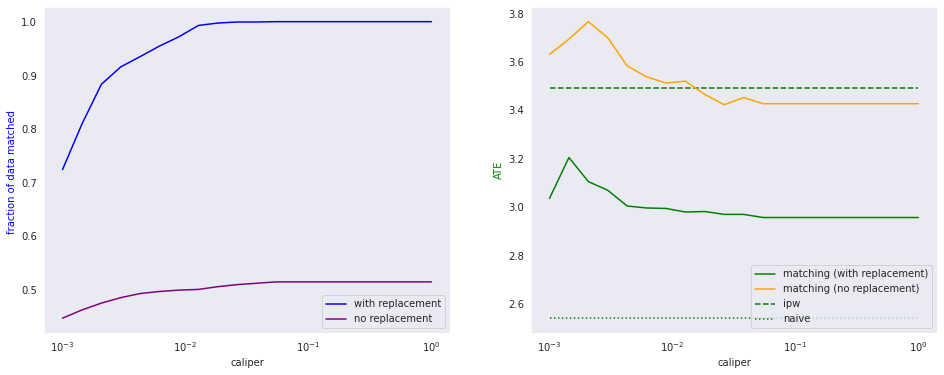

In [17]:
with sb.axes_style("dark") as s:
    f, ax = plt.subplots(1, 2, figsize=(16, 6))

    ax[0].semilogx(caliper, p_with, "blue", label="with replacement")
    ax[0].semilogx(caliper, p_without, "purple", label="no replacement")
    ax[0].set_ylabel("fraction of data matched ", color="blue")
    ax[0].legend()
    ax[0].set_xlabel("caliper")

    ax[1].semilogx(caliper, ATE_with, "green",
                   label="matching (with replacement)")
    ax[1].semilogx(caliper, ATE_without, "orange",
                   label="matching (no replacement)")
    ax[1].set_ylabel("ATE", color="green")
    ax[1].hlines(xmin=caliper.min(), xmax=caliper.max(),
                 y=ATE_ipw, ls="--", color="green", label="ipw")
    ax[1].hlines(xmin=caliper.min(), xmax=caliper.max(),
                 y=ATE_naive, ls=":", color="green", label="naive")
    ax[1].legend(loc=4)
    ax[1].set_xlabel("caliper");

# Intermediate results
The `Matching` object implements `IndividualOutcomeEstimator`, specifically the `fit` and `estimate_individual_outcome` methods. Because matching has many uses, `Matching` also outputs a DataFrame of matches and a vector of weights. These can be used for filtering data before applying regression, for example, or for assessing the quality of the covariate balancing (as shown above).

In [18]:
matcher = Matching(with_replacement=False, propensity_transform=propensity_transform)
matcher.fit(X, a, y)
match_df = matcher.match(X, a)
match_df

distances matches
match_to_treatment sample_id                                  
1                  0                                []      []
                   1                                []      []
                   2          [0.00020765596476873815]   [819]
                   3           [0.0001142785835505089]  [1564]
                   4           [6.015153572747067e-05]   [731]
...                                                ...     ...
0                  1623                             []      []
                   1624                             []      []
                   1625                             []      []
                   1627                            [0]  [1627]
                   1628        [2.757121594376688e-05]    [28]

[3132 rows x 2 columns]

The matching DataFrame can be understood in the following way: when sample `sample_id` searched for a match with treatment value `match_to_treatment` it found the samples indexed in `matches` which were located at distances according to the `distances` entry. If `matches` is empty it means `sample_id` had no match in treatment class `match_to_treatment`. This allows us to handle the case with multiple matches, as well as with uneven numbers of matches due to the caliper constraint:

In [19]:
matcher = Matching(with_replacement=True, 
                   propensity_transform=propensity_transform, 
                   n_neighbors=3,
                   caliper=0.001).fit(X, a, y)
match_df_3 = matcher.match(X, a)
match_df_3

distances matches
match_to_treatment sample_id                                 
0                  0                              [0]     [0]
                   1                              [0]     [1]
                   2                              [0]     [2]
                   3                              [0]     [3]
                   4                              [0]     [4]
...                                               ...     ...
1                  1623                            []      []
                   1624                            []      []
                   1625                            []      []
                   1627       [0.0007702527722480701]  [1202]
                   1628                           [0]  [1628]

[3132 rows x 2 columns]

We can also output weights which can be useful for comparing with other methods or preparing the data for further processing:


In [20]:
weights_df = matcher.matches_to_weights(match_df)
weights_df

,control_to_treatment,treatment_to_control
0,0.0,0.0
1,0.0,0.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
1623,0.0,0.0
1624,0.0,0.0
1625,0.0,0.0
1627,1.0,1.0


We distinguish between matching from 0 to 1 and from 1 to 0 because in general they are distinct processes which can have different weights. For the case with no replacement the two columns are identical and always only 1 or 0. We see this when we examine the weights obtained with replacement, caliper and 3 neighbors.

In [21]:
weights_df_3 = matcher.matches_to_weights(match_df_3)
weights_df_3

,control_to_treatment,treatment_to_control
0,0.0,0.000000
1,1.0,0.333333
2,1.0,0.500000
3,1.0,1.000000
4,1.0,1.000000
...,...,...
1623,0.0,0.000000
1624,0.0,0.000000
1625,0.0,0.000000
1627,1.0,0.500000


The columns no longer match because a given treatment sample may be selected multiple times when matched from the set of control samples. Each selection increases its weight. However, if it is one of $n$ chosen samples it is only increased by $1/n$. 

## Compare Covariate Balancing with IPW
Using the weights we can compare how well the matching algorithm balances the covariate distributions, compared to IPW. Even though IPW is a population effect estimator and matching is an individual outcome estimator, their results can both be expressed as weights and compared using `calculate_covariate_balance`.

In [22]:
ipw = IPW(LogisticRegression(solver="liblinear"))
ipw.fit(X, a)
ipw_binarized_weights = ipw.compute_weights(X, a)

In [23]:
matcher = Matching(with_replacement=True, 
                   propensity_transform=propensity_transform, 
                   caliper=0.01).fit(X, a, y)
match_df = matcher.match(X, a)
weights_df = matcher.matches_to_weights(match_df)
covbal = {}
covbal["match_control_to_treatment"] = calculate_covariate_balance(
    X, a, w=weights_df.control_to_treatment)
covbal["match_treatment_to_control"] = calculate_covariate_balance(
    X, a, w=weights_df.treatment_to_control)
covbal["ipw_binarized"] = calculate_covariate_balance(
    X, a, w=ipw_binarized_weights)
covbal["match_both"] = calculate_covariate_balance(
    X, a, w=weights_df.sum(axis=1))


for k in covbal:
    covbal[k] = covbal[k].drop(
        columns="unweighted") if not "both" in k else covbal[k]

covbal_df = pd.concat(covbal, axis=1)
covbal_df.columns = list(covbal.keys()) + ["unweighted"]
covbal_df

,match_control_to_treatment,match_treatment_to_control,ipw_binarized,match_both,unweighted
covariate,,,,,
age,0.006342,0.041015,0.020927,0.015400,0.199560
race,0.025248,0.076893,0.076369,0.001435,0.125194
sex,0.057555,0.000000,0.035016,0.042519,0.113323
smokeintensity,0.073808,0.013738,0.012758,0.050938,0.153345
smokeyrs,0.021422,0.043703,0.008709,0.027242,0.112470
wt71,0.102190,0.005927,0.014270,0.073946,0.094278
active_1,0.051302,0.084923,0.024493,0.060085,0.018961
active_2,0.033199,0.011735,0.014842,0.027592,0.052327
education_2,0.009262,0.017462,0.000102,0.011404,0.078944


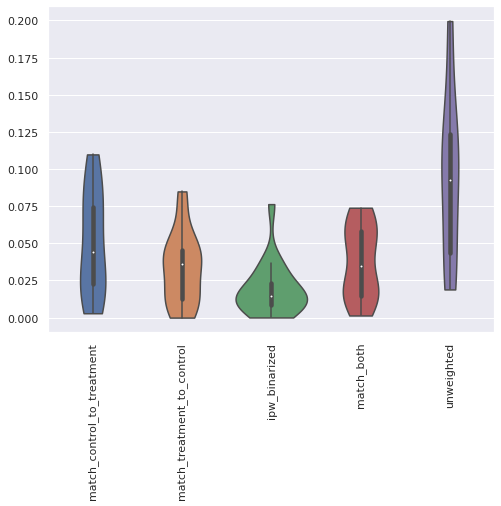

In [24]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set("notebook")
f, axes = plt.subplots(figsize=(8, 6))
sb.violinplot(data=covbal_df, ax=axes, cut=0)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90);

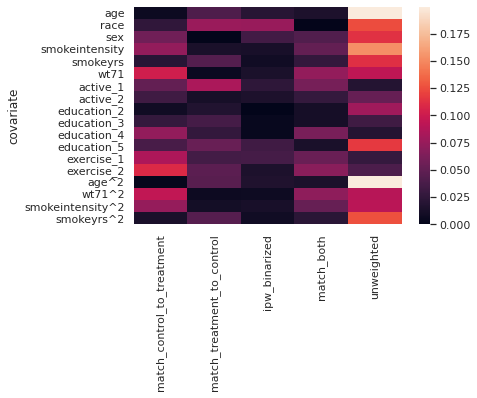

In [25]:
sb.heatmap(data=covbal_df);

Comparing the results of the IPW weights and the matching weights, we see that while both lead to substantially better weighted covariates, the IPW does a better job in general. In the Lalonde matching notebook, we will show how matching and IPW an be used together to obtain even better covariate distribution balancing.